#### Link Prediction 

Overall, this algorithm does not train a supervised model. Instead, it directly computes a hand-crafted score based on:

Chemical Descriptors – Tanimoto similarity between Morgan fingerprints of drugs.
Network Features – Node centralities and community labels.

It then evaluates how well that score ranks existing (positive) drug–target interactions over randomly chosen (negative) pairs.

#### Positive and Negative Sample Generation

Positive Pairs (Edges): Real edges already present in the bipartite graph (i.e., known drug–target links).
Negative Pairs (Non-Edges): Randomly chosen drug–target pairs that have no edge in the graph. The code ensures it picks approximately as many negative pairs as positive ones.

Given a candidate edge between a drug node u and a target node v, the code defines a scoring function that combines chemical similarity with network feature similarity:

Chemical Similarity: Looks at all the drug neighbors of the target node. For each neighbor (which is also a drug), it retrieves its Tanimoto similarity with the drug of interest, u. Then it averages these similarities. If the target node has no drug neighbors, or the drug node lacks a fingerprint, this portion defaults to 0.
Network Feature Similarity:
Gathers the node-level features for u and v (degree, betweenness, etc.).
Takes the absolute differences of these values, then averages them.
Inverts that average difference to create a similarity measure (so a smaller difference in centralities => a higher similarity).

##### Combined Score:


```score = alpha * (chemical similarity) + beta * (network similarity)``` 

with alpha and beta typically set to 0.5 each.    

[12:16:26] WARNING: not removing hydrogen atom without neighbors


ROC-AUC: 0.8124
PR-AUC:  0.8382


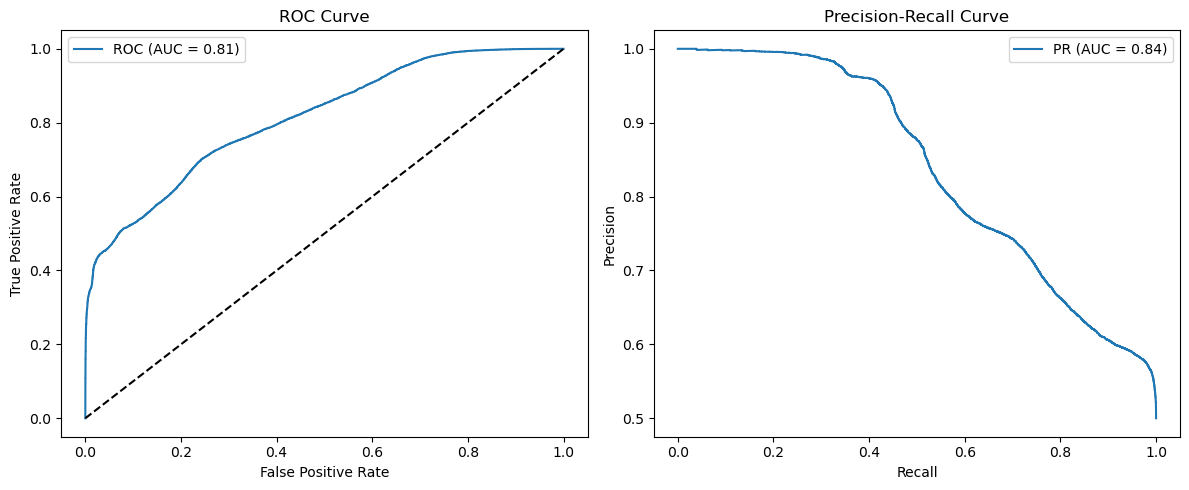

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

#========================================================
#                 Data Loading
#========================================================
df = pd.read_csv('data/drug_target_data_short.csv')

#========================================================
#               Bipartite Graph Setup
#========================================================
B = nx.Graph()

drugs = df['DRUG_NAME'].unique()
targets = df['TARGET_NAME'].unique()

drug_to_idx = {drug: idx for idx, drug in enumerate(drugs)}
target_to_idx = {target: idx + len(drugs) for idx, target in enumerate(targets)}

for _, row in df.iterrows():
    B.add_edge(drug_to_idx[row['DRUG_NAME']],
               target_to_idx[row['TARGET_NAME']])

#========================================================
#         Morgan Fingerprints via rdFingerprintGenerator
#========================================================
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def get_morgan_fingerprint(smiles_str):
    mol = Chem.MolFromSmiles(smiles_str)
    if mol is None:
        # Fallback or handling for invalid SMILES
        return None
    return mfpgen.GetFingerprint(mol)

drug_fingerprints = {}
for drug, smiles in df[['DRUG_NAME', 'SMILES']].drop_duplicates().values:
    drug_idx = drug_to_idx[drug]
    fp = get_morgan_fingerprint(smiles)
    if fp is not None:
        drug_fingerprints[drug_idx] = fp

#========================================================
#         Precompute Drug–Drug Tanimoto Similarities
#========================================================
drug_nodes = list(drug_fingerprints.keys())
drug_sim_matrix = {i: {} for i in drug_nodes}

for i in drug_nodes:
    for j in drug_nodes:
        fp_i = drug_fingerprints[i]
        fp_j = drug_fingerprints[j]
        sim  = DataStructs.FingerprintSimilarity(fp_i, fp_j)
        drug_sim_matrix[i][j] = sim

#========================================================
#            Compute Node-level Network Features
#========================================================
def calculate_network_features(G):
    degree         = nx.degree_centrality(G)
    betweenness    = nx.betweenness_centrality(G)
    closeness      = nx.closeness_centrality(G)
    pagerank       = nx.pagerank(G)

    # Greedy modularity-based communities
    communities = nx.algorithms.community.greedy_modularity_communities(G)
    community_map = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            community_map[node] = idx

    core_number = nx.core_number(G)

    return {
        'degree': degree,
        'betweenness': betweenness,
        'closeness': closeness,
        'pagerank': pagerank,
        'community': community_map,
        'core_number': core_number
    }

network_features = calculate_network_features(B)

#========================================================
#      Similarity + Network-Feature Scoring Function
#========================================================
def predict_link_score(drug_node, target_node, graph, drug_sim, net_feats):
    """
    Returns a link score by combining:
      1) Average Tanimoto similarity between the 'drug_node' and
         each known drug neighbor of 'target_node'.
      2) A node-level network "similarity," based on absolute
         differences in features (we invert to convert difference
         to a similarity metric).
    """

    # (1) Average Tanimoto similarity with neighbors
    neighbors_of_target = [n for n in graph.neighbors(target_node) if n in drug_nodes]
    if len(neighbors_of_target) == 0:
        sim_score = 0.0
    else:
        sim_scores = [drug_sim[drug_node][nbr] for nbr in neighbors_of_target if nbr in drug_sim[drug_node]]
        sim_score = np.mean(sim_scores) if len(sim_scores) > 0 else 0.0

    # (2) Node-level features for drug_node (u) & target_node (v)
    fts_drug   = [
        net_feats['degree'].get(drug_node, 0),
        net_feats['betweenness'].get(drug_node, 0),
        net_feats['closeness'].get(drug_node, 0),
        net_feats['pagerank'].get(drug_node, 0),
        net_feats['community'].get(drug_node, 0),
        net_feats['core_number'].get(drug_node, 0),
    ]
    fts_target = [
        net_feats['degree'].get(target_node, 0),
        net_feats['betweenness'].get(target_node, 0),
        net_feats['closeness'].get(target_node, 0),
        net_feats['pagerank'].get(target_node, 0),
        net_feats['community'].get(target_node, 0),
        net_feats['core_number'].get(target_node, 0),
    ]

    abs_diffs = [abs(a - b) for a, b in zip(fts_drug, fts_target)]
    net_diff = np.mean(abs_diffs)
    net_sim  = 1.0 / (1.0 + net_diff)  # convert difference to similarity

    # Weighted combination
    alpha = 0.5
    beta  = 0.5
    score = alpha * sim_score + beta * net_sim

    return score

#========================================================
#        Generate Positive and Negative Samples
#========================================================
positive_pairs = list(B.edges())

negative_pairs = []
nodes = list(B.nodes())
np.random.seed(101)

while len(negative_pairs) < len(positive_pairs):
    u, v = np.random.choice(nodes, 2, replace=False)
    
    # One node (u) is a drug (i.e., its index is less than len(drugs)).
    #The other node (v) is a target (i.e., its index is greater or equal to len(drugs)).
    # This ensures the pair (u, v) is always a drug–target pair rather than two drugs or two targets.
    
    if (u < len(drugs) and v >= len(drugs)) or (v < len(drugs) and u >= len(drugs)):
        if not B.has_edge(u, v):
            negative_pairs.append((u, v))

#========================================================
#             Compute Scores and Labels
#========================================================
all_scores = []
all_labels = []

for (u, v) in positive_pairs:
    # Ensure "u" is drug, "v" is target
    if u >= len(drugs):
        u, v = v, u
    # If the drug node is missing a fingerprint, skip
    if u not in drug_fingerprints:
        continue
    score = predict_link_score(u, v, B, drug_sim_matrix, network_features)
    all_scores.append(score)
    all_labels.append(1)

for (u, v) in negative_pairs:
    if u >= len(drugs):
        u, v = v, u
    if u not in drug_fingerprints:
        continue
    score = predict_link_score(u, v, B, drug_sim_matrix, network_features)
    all_scores.append(score)
    all_labels.append(0)

all_scores = np.array(all_scores)
all_labels = np.array(all_labels)

#========================================================
#                   Evaluation
#========================================================
auc_score = roc_auc_score(all_labels, all_scores)
precision, recall, _ = precision_recall_curve(all_labels, all_scores)
pr_auc = auc(recall, precision)

print(f"ROC-AUC: {auc_score:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")

#========================================================
#                 Visualization
#========================================================
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#========================================================
#                   Evaluation
#========================================================
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve,
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    average_precision_score
)


# ------------------- Evaluation Metrics -----------------#
# 1) Average Precision
ap_score = average_precision_score(all_labels, all_scores)
print(f"Average Precision: {ap_score:.4f}")

# 2) Threshold-based classification
#    Convert continuous scores into predicted classes (0/1).
threshold = 0.5
pred_classes = (all_scores >= threshold).astype(int)

acc = accuracy_score(all_labels, pred_classes)
ba  = balanced_accuracy_score(all_labels, pred_classes)
f1  = f1_score(all_labels, pred_classes)

print(f"Accuracy (threshold={threshold}): {acc:.4f}")
print(f"Balanced Accuracy (threshold={threshold}): {ba:.4f}")
print(f"F1 Score (threshold={threshold}): {f1:.4f}")

# 3) Confusion Matrix
tn, fp, fn, tp = confusion_matrix(all_labels, pred_classes).ravel()
print(f"Confusion Matrix (threshold={threshold}):")
print(f"  TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# 4) Sensitivity & Specificity
#    Sensitivity (Recall) = TP / (TP + FN)
#    Specificity = TN / (TN + FP)
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

ROC-AUC: 0.8124
PR-AUC:  0.8382
Average Precision: 0.8382
Accuracy (threshold=0.5): 0.6957
Balanced Accuracy (threshold=0.5): 0.6957
F1 Score (threshold=0.5): 0.5736
Confusion Matrix (threshold=0.5):
  TN: 15896, FP: 288, FN: 9560, TP: 6624
Sensitivity (Recall): 0.4093
Specificity: 0.9822
